In [62]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.src.metrics import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import itertools
from matplotlib import pyplot as plt


In [2]:
# Renaiming columns
columns = ['letter', 'x-box', 'y-box', 'width', 'high', 'onpix', 
              'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 
              'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']

df = pd.read_csv("letter-recognition.data", header=None, names=columns)
df

,letter,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


## One-Hot encoding 

In [3]:
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df).toarray()
df_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [4]:
def build_indices(df, columns):
    indices = {}
    prev = 0
    for i in range(len(columns)):
        if i == 0:
            succ = len(df[columns[i]].unique())
            indices[i] = range(prev, succ)
        else:
            succ = prev + len(df[columns[i]].unique())
            indices[i] = range(prev, succ)
        prev = succ
    return indices

In [5]:
"""
indices = {
    0: range(0, 26), # letters
    1: range(26, 42), # x-box
    2: range(42, 58), # y-box
    3: range(58, 74), # width
    4: range(74, 90), # high
    5: range(90, 106), # on-pix
    6: range(106, 122), # x-bar
    7: range(122, 138), # y-bar
    8: range(138, 154), # x2bar
    9: range(154, 170), # y2bar
    10: range(170, 186), # xybar
    11: range(186, 202), #x2ybr
    12: range(202, 218), # xy2br
    13: range(218, 234), # x-ege
    14: range(234, 250), # xegvy
    15: range(250, 266), # y-ege
    16: range(266, 282) # yegvx
}
"""

indices = build_indices(df, columns)
indices


{0: range(0, 26),
 1: range(26, 42),
 2: range(42, 58),
 3: range(58, 74),
 4: range(74, 90),
 5: range(90, 106),
 6: range(106, 122),
 7: range(122, 138),
 8: range(138, 154),
 9: range(154, 170),
 10: range(170, 186),
 11: range(186, 202),
 12: range(202, 218),
 13: range(218, 234),
 14: range(234, 250),
 15: range(250, 266),
 16: range(266, 282)}

## I'm going to simulate missing values from the dataset
### I'm going to randomly set some values to 0 in every row
### The original dataset will be set as Target

In [26]:
import itertools
import numpy as np

def adding_missing_values(data, indices, k, m):
    X = data.copy()
    numbers = list(indices.keys())  # list of symbolic variable indices
    combinations = itertools.combinations(numbers, k)  # all possible combinations of k variables

    for comb in combinations:
        # Choose m random rows
        rows = np.random.choice(X.shape[0], m, replace=False)
   
        
        for col in comb:
            column_indices = list(indices[col])
            for j in column_indices:
                X[rows, j] = 0.0

    return X


In [9]:
df_encoded_copy = df_encoded.copy()
X_missing_values = adding_missing_values(df_encoded_copy, indices, 1, 100)

X_missing_values


Selected rows: [ 7126  7367 18356 11038 11909  9150 14514  3299 12442 15051  4732  1811
 15108  9450  8984 14734 19721  5773 16039   440  1987 15592 19951   416
  2232 12727  7897  7479  7922  3581 16917 10749  7564 14078 12046  7598
   368  5222 19919  8203 15437  1295  1684 18827 15244 12780  6739  9378
 16524 14370  2392  6633 14295  9697  5279 19871  3426 14230 18189 15566
  1950 15614   663 19186 14710  2714  3409 11462 15026 14970  9489 14769
  2561  9929  3618  3690  3701 10184 10309 15335 12898  6646  8989  1235
  7571 16230  1506  9954 19406 15017  7524  1891 17028 13257 18892  2439
 16565 18969  1215  7164]
Selected symbolic variables (by index): (0,)
Zeroing out columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] (corresponding to variable 0)

Selected rows: [ 4490 17671 18912 16629 15233 14538  6014  3525 17691  6740 10713 19908
 13786 16711 11200  8276 17158  2171 11035  1394 18310 18579  3224  3532
 18981 17820 13451 148

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

## Prepare Data for training and testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_missing_values, df_encoded_copy, test_size=0.2, random_state=42)


# Constructing MLP using Keras

In [12]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')  # output binario
])

In [13]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy(name="bit_accuracy")])


# Training the model

In [314]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - bit_accuracy: 0.9431 - loss: 0.1671 - val_bit_accuracy: 0.9700 - val_loss: 0.0865
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9814 - loss: 0.0569 - val_bit_accuracy: 0.9886 - val_loss: 0.0375
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9921 - loss: 0.0274 - val_bit_accuracy: 0.9940 - val_loss: 0.0215
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9956 - loss: 0.0162 - val_bit_accuracy: 0.9960 - val_loss: 0.0145
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9972 - loss: 0.0107 - val_bit_accuracy: 0.9971 - val_loss: 0.0106
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9981 - loss: 0.0077 - val_bit_accuracy: 0.9977 - val_loss: 0.0086
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9987 - loss: 0.0057 - val_bit_accuracy: 0.9981 - val_loss: 0.0070
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

# Testing


In [15]:
# Predizione
y_pred = model.predict(X_test)

# Binarizzazione con soglia 0.8
y_pred_binary = (y_pred > 0.8).astype(int)

# Accuracy su tutti i bit
accuracy_letter1 = (y_pred_binary == y_test).mean()

# Accuracy solo sui bit mancanti
test_mask = (X_test != 0).astype(int)
missing_mask = (test_mask == 0)
correct_missing = (y_pred_binary == y_test) & missing_mask
accuracy_missing = correct_missing.sum() / missing_mask.sum()

print(accuracy_missing)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
0.9996708630837583


# Now i'm gonna test if the model can predict missing values using a different value of K

In [59]:
df_encoded_copy2 = df_encoded.copy()
X_missing_values2 = adding_missing_values(df_encoded_copy2, indices, 4, 300)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_missing_values2, df_encoded_copy2, test_size=0.2, random_state=42)

input_dim = X_train2.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')  # output binario
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy(name="bit_accuracy")])

history2 = model.fit(
    X_train2, y_train2,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred2 = model.predict(X_test2)
y_pred_binary2 = (y_pred2 > 0.8).astype(int)
accuracy_letter2 = (y_pred_binary2 == y_test2).mean()

test_mask2 = (X_test2 != 0).astype(int)  # 1 = osservato, 0 = mancato
missing_mask2 = (test_mask2 == 0)

# Calcola solo dove i bit erano mancanti
correct_missing2 = (y_pred_binary2 == y_test2) & missing_mask2
accuracy_missing2 = correct_missing2.sum() / missing_mask2.sum()
print(accuracy_missing2)

ERROR! Session/line number was not unique in database. History logging moved to new session 590
Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9397 - loss: 0.3137 - val_bit_accuracy: 0.9397 - val_loss: 0.1889
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9397 - loss: 0.1892 - val_bit_accuracy: 0.9397 - val_loss: 0.1887
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - bit_accuracy: 0.9397 - loss: 0.1891 - val_bit_accuracy: 0.9397 - val_loss: 0.1886
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bit_accuracy: 0.9397 - loss: 0.1891 - val_bit_accuracy: 0.9397 - val_loss: 0.1886
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bit_accuracy: 0.9397 - loss: 0.1890 - val_bit_accuracy: 0.9397 - val_loss: 0.1886
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bit_accuracy: 0.9397 - loss: 0.1890 - val_bit_accuracy: 0.9397 - val_loss: 0.1886
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bit_accuracy: 0.9397 - loss: 0.189

# LETS CONSIDER NOW THE SECOND DATASET

In [44]:
# Load the dataset
columns2 = ["buying", "maint", "doors", "persons", "lug_boot",
            "safety", "class"]
df2 = pd.read_csv("car.data", delimiter=",", header=None, names=columns2)
df2

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


# One-Hot Encoding

In [45]:
df2_encoded = encoder.fit_transform(df2).toarray()
df2_encoded

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [46]:
"""
indices2 = {
    0: range(0, 4), # buying
    1: range(4, 8), # maint
    2: range(8, 12), # doors
    3: range(12, 15), # persons
    4: range(15, 18), # lug_boot
    5: range(18, 21), # safety
    6: range(21, 25) #class
}
"""
indices2 = build_indices(df2, columns2)
indices2

{0: range(0, 4),
 1: range(4, 8),
 2: range(8, 12),
 3: range(12, 15),
 4: range(15, 18),
 5: range(18, 21),
 6: range(21, 25)}

In [47]:
X_df2 = adding_missing_values(df2_encoded, indices2, 1, 100)
y2 = df2_encoded.copy()

In [34]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X_df2, y2, test_size=0.2, random_state=42)


In [35]:
input_dim_car = X3_train.shape[1]

model_car = keras.Sequential([
    layers.Input(shape=(input_dim_car,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim_car, activation='sigmoid')
])
model_car.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy(name="bit_accuracy")])


In [58]:
X_df4 = adding_missing_values(df2_encoded, indices2, 4, 300)
y4 = df2_encoded.copy()

X4_train, X4_test, y4_train, y4_test = train_test_split(X_df4, y4, test_size=0.2, random_state=42)

input_dim_car = X4_train.shape[1]

model_car = keras.Sequential([
    layers.Input(shape=(input_dim_car,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim_car, activation='sigmoid')
])
model_car.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy(name="bit_accuracy")])

history4 = model_car.fit(
    X4_train, y4_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predict
y_pred4 = model_car.predict(X4_test)

# Binarize output
y_pred_binary4 = (y_pred4 > 0.8).astype(int)

# Global accuracy
accuracy_car4 = (y_pred_binary4 == y4_test).mean()

# Accuracy only on missing bits
test_mask4 = (X4_test != 0).astype(int)
missing_mask4 = (test_mask4 == 0)
correct_missing4 = (y_pred_binary4 == y4_test) & missing_mask4
accuracy_missing4 = correct_missing4.sum() / missing_mask4.sum()

print(accuracy_missing4)


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - bit_accuracy: 0.7293 - loss: 0.6653 - val_bit_accuracy: 0.7320 - val_loss: 0.6147
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bit_accuracy: 0.7376 - loss: 0.5748 - val_bit_accuracy: 0.7320 - val_loss: 0.5668
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bit_accuracy: 0.7376 - loss: 0.5562 - val_bit_accuracy: 0.7320 - val_loss: 0.5640
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bit_accuracy: 0.7376 - loss: 0.5537 - val_bit_accuracy: 0.7320 - val_loss: 0.5642
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bit_accuracy: 0.7378 - loss: 0.5523 - val_bit_accuracy: 0.7321 - val_loss: 0.5642
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bit_accuracy: 0.7387 - loss: 0.5508 - val_bit_accuracy: 0.7324 - val_loss: 0.5644
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bit_accuracy: 0.7405 - loss: 0.5490 - val_bit_accuracy: 0.7339 - val_loss: 0.5639
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bit_accura

# Now i'm gonna test if the model can predict missing values using a different value of K


In [55]:
df_encoded_copy4 = df2_encoded.copy()

X_missing_values4 = adding_missing_values(df_encoded_copy4, indices, 1, 100)
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X_missing_values4, y2, test_size=0.2, random_state=42
)
input_dim_car = X_train4.shape[1]

model_car = keras.Sequential([
    layers.Input(shape=(input_dim_car,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim_car, activation='sigmoid')
])
model_car.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy(name="bit_accuracy")])
history4 = model_car.fit(
    X_train4, y_train4,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred4 = model_car.predict(X_test4)
y_pred_binary4 = (y_pred4 > 0.8).astype(int)

accuracy_car4 = ((y_pred_binary4 == y_test4).values).mean()

# Accuracy only on missing values
test_mask4 = (X_test4 != 0).astype(int)
missing_mask4 = (test_mask4 == 0)
correct_missing4 = (y_pred_binary4 == y_test4) & missing_mask4
accuracy_missing4 = correct_missing4.sum() / missing_mask4.sum()
print("Accuracy on missing values:", accuracy_missing4)


IndexError: index 25 is out of bounds for axis 1 with size 25

# Plotting Results

In [63]:
results = {
    "Letters (1-miss)": {"bitwise": accuracy_letter1, "missing": accuracy_missing},
    "Letters (4-miss)": {"bitwise": accuracy_letter2, "missing": accuracy_missing2},
    "Cars (1-miss)": {"bitwise": accuracy_car3, "missing": accuracy_missing3},
    "Cars (4-miss)": {"bitwise": accuracy_car4, "missing": accuracy_missing4}
}


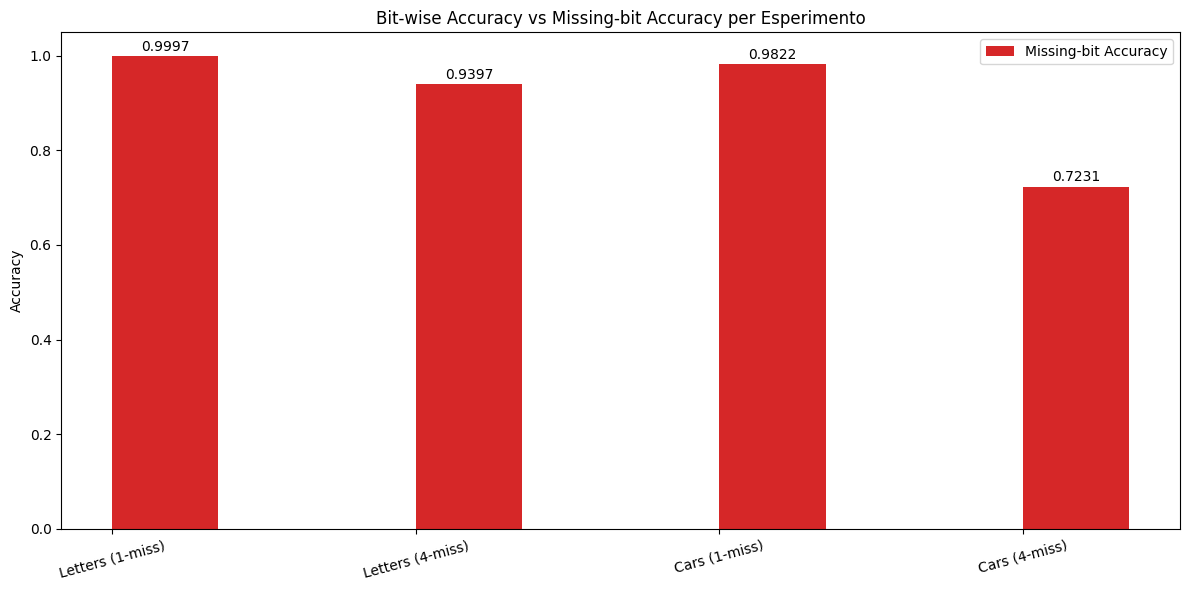

In [64]:

labels = list(results.keys())
bitwise = [results[exp]["bitwise"] for exp in labels]
missing = [results[exp]["missing"] for exp in labels]

# Setup
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars2 = ax.bar(x + width/2, missing, width, label="Missing-bit Accuracy", color='tab:red')

for i in range(len(labels)):
    ax.text(x[i] + width/2, missing[i] + 0.005, f"{missing[i]:.4f}", ha='center', va='bottom', fontsize=10)

ax.set_ylabel("Accuracy")
ax.set_title("Bit-wise Accuracy vs Missing-bit Accuracy per Esperimento")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()
